In [2]:
import os
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
import logging
logger = logging.getLogger()
logger.setLevel(logging.WARNING)
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import multiprocessing
import itertools as it
from scipy.special import expit
import pymc3 as pm
import arviz as az
import theano.tensor as tt
import warnings
warnings.simplefilter('ignore')

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

# Make data

In [5]:
np.random.seed(123)

In [6]:
def u(x, alpha):
    return x**(1 - alpha)

def f_choice(x, tau):
    return expit(x*(1/tau))

In [7]:
# steps = np.linspace(0.01,0.99, 10)
# task = pd.DataFrame(np.array(list(it.product(steps, repeat=4))), columns=["p0", "x0", "p1", "x1"])
task = pd.DataFrame(np.random.random(size=(1000, 4)), columns=["p0", "x0", "p1", "x1"])
task = task[~((task.p0 >= task.p1) & (task.x0 >= task.x1))]
task = task[~((task.p1 >= task.p0) & (task.x1 >= task.x0))]

In [8]:
n_trial = len(task)

true_tau = 0.3
true_alpha = 0.4

seu0 = task.p0 * u(task.x0, true_alpha)
seu1 = task.p1 * u(task.x1, true_alpha)

diff_eu = seu1 - seu0
task['diff_eu'] = diff_eu

p_choice_1 = f_choice(diff_eu, true_tau)

choice = np.zeros(n_trial, dtype=int)
choice[:] = p_choice_1 > np.random.random(size=n_trial)
task["choice"] = choice

n = 100
task = task.sample(n=n, replace=False)
task = task.sort_values(by="diff_eu")
task.reset_index(inplace=True, drop=True)
task

,p0,x0,p1,x1,diff_eu,choice
0,0.610272,0.911365,0.060995,0.991708,-0.516526,0
1,0.931932,0.582175,0.206096,0.717758,-0.504712,0
2,0.769397,0.573774,0.102635,0.699834,-0.468459,0
3,0.782821,0.558396,0.133484,0.829552,-0.432533,0
4,0.654901,0.596849,0.072152,0.632890,-0.425668,1
...,...,...,...,...,...,...
95,0.729661,0.157371,0.692422,0.730335,0.332846,1
96,0.166744,0.828984,0.912390,0.391699,0.370941,0
97,0.020576,0.918097,0.864480,0.276902,0.380536,0
98,0.129865,0.859377,0.571432,0.836710,0.394886,1


In [9]:
p0 = task.p0.values
p1 = task.p1.values
x0 = task.x0.values
x1 = task.x1.values
y = task.choice.values
diff_eu = task.diff_eu.values

x = np.hstack((x0, x1))
p = np.hstack((p0, p1))
x_order = np.argsort(x)
x_sorted = x[x_order]
undo_sorted = np.argsort(x_order)

u_sorted = u(x_sorted, true_alpha)
p_sorted = p[x_order]
eu_sorted = p_sorted*u_sorted
p_choice1 = f_choice(diff_eu, true_tau)

# How does it look like

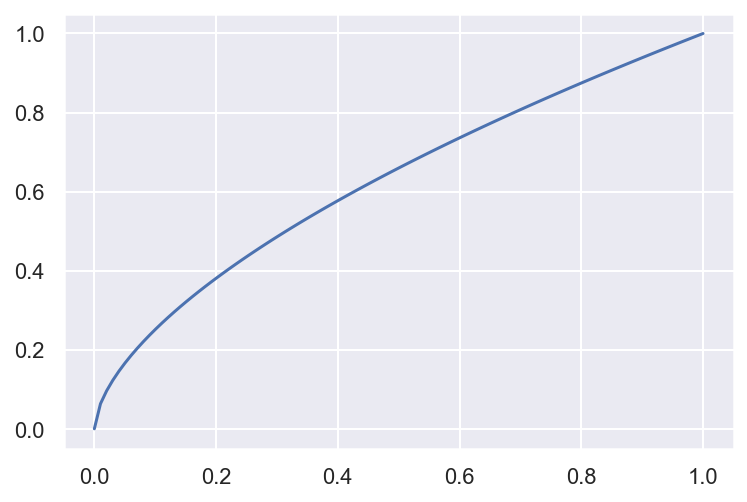

In [10]:
x_plot = np.linspace(0, 1, 100)
plt.plot(x_plot, u(x_plot, true_alpha))

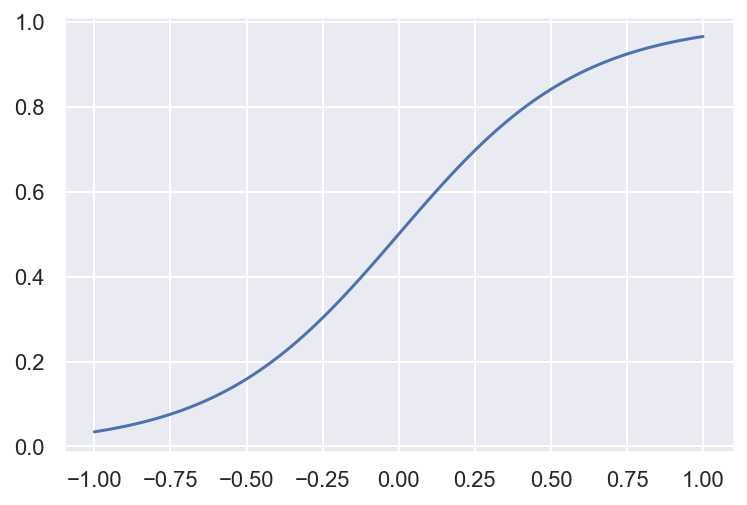

In [11]:
x_plot = np.linspace(-1, 1, 100)
plt.plot(x_plot, f_choice(x_plot, true_tau))

# Naive approach

In [12]:
with pm.Model() as model:

    ρ = pm.InverseGamma('ρ', 2, 2)     # Lengthscale
    η = pm.HalfCauchy('η', 5)          # Vertical variation
    
    α = pm.TruncatedNormal('α', 1, 1000, lower=-1)
    
    X = x_sorted.reshape(-1, 1)
    
    M = pm.gp.mean.Linear(coeffs=0)
    K = η**2 * pm.gp.cov.ExpQuad(1, ρ) 
    
    gp = pm.gp.Latent(mean_func=M, cov_func=K)
    f = gp.prior("f", X=X)

    est_eu =  p_sorted * f    
    est_eu_unsorted = est_eu[undo_sorted]
    
    diff_eu_hat = pm.Deterministic("diff_eu_hat", est_eu_unsorted[n:] - est_eu_unsorted[:n])
    
    tau_hat = true_tau
    est_p_choice1 = pm.Deterministic('est_p_choice1', pm.math.invlogit((1/tau_hat)*diff_eu_hat))
    choose_1 = pm.Bernoulli('choose_1', p=est_p_choice1, observed=y)

## Not really working only with MAP

In [20]:
with model:
    mp = pm.find_MAP()

In [21]:
# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples = pm.sample_posterior_predictive([mp, ], var_names=["f"], samples=1000)

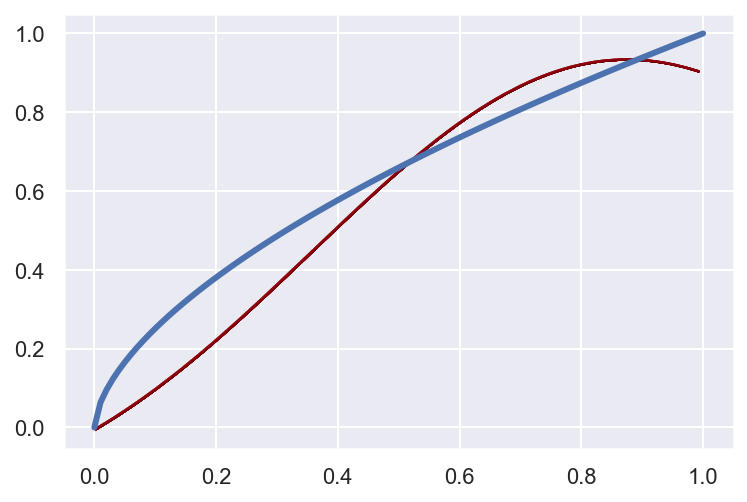

In [22]:
fig, ax = plt.subplots()
pm.gp.util.plot_gp_dist(ax, pred_samples["f"], x_sorted)
ax.plot(x_plot, u(x_plot, alpha=true_alpha), lw=3)

## With MCMC

In [23]:
with model:
    trace = pm.sample(1000, tune=2000, chains=2, return_inferencedata=True, 
                      target_accept=0.90)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [f_rotated_, α, η, ρ]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 578 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


<AxesSubplot:>

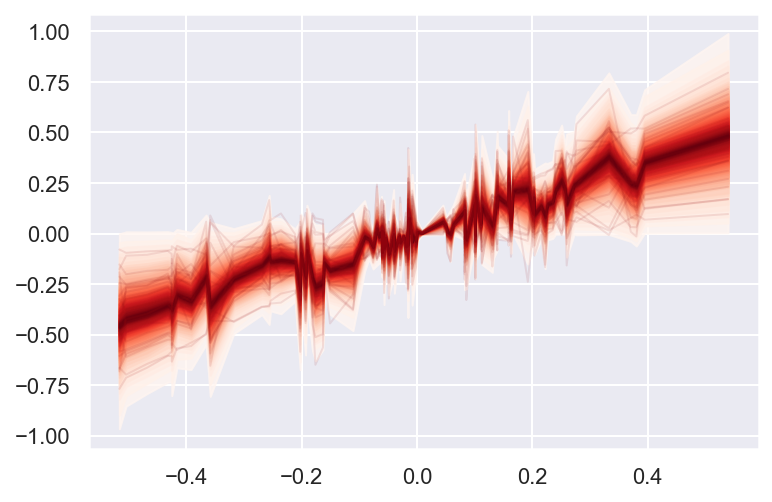

In [24]:
fig, ax = plt.subplots()
pm.gp.util.plot_gp_dist(ax, trace.posterior["diff_eu_hat"][0, :, :], diff_eu)

<AxesSubplot:>

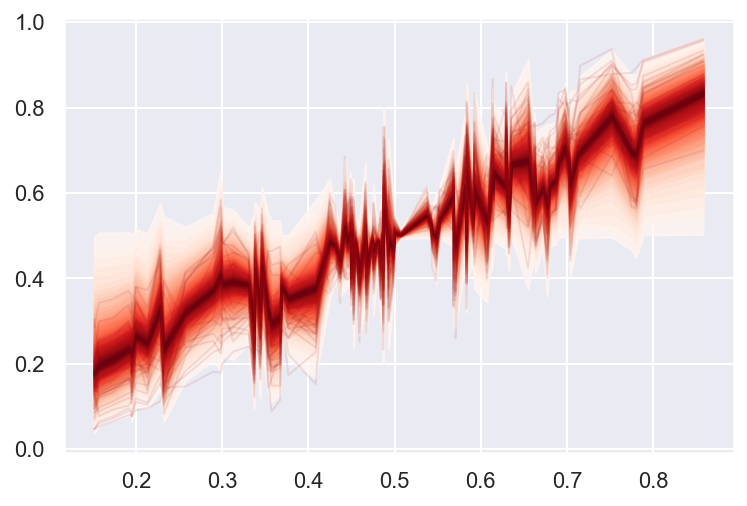

In [25]:
fig, ax = plt.subplots()
pm.gp.util.plot_gp_dist(ax, trace.posterior["est_p_choice1"][0, :, :], p_choice1)

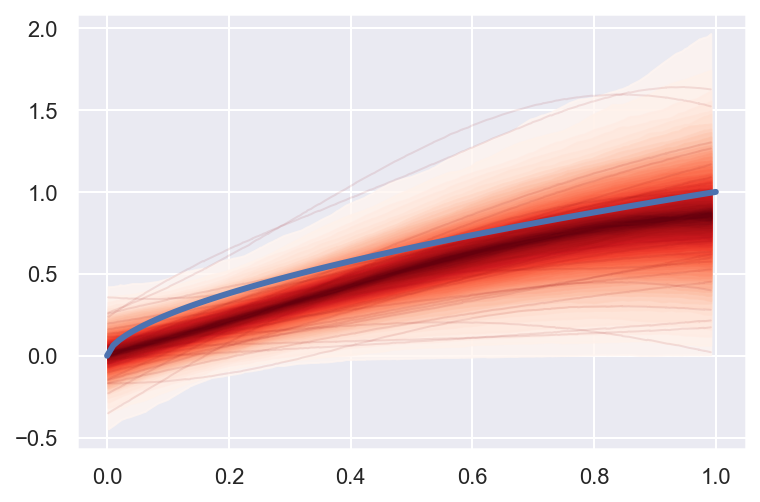

In [26]:
fig, ax = plt.subplots()
pm.gp.util.plot_gp_dist(ax, trace.posterior["f"][0, :, :], x_sorted)

x_plot = np.linspace(0, 1, 100)
# ax.scatter(x_sorted, u(x_sorted, alpha=true_alpha), color='b', alpha=0.2)
ax.plot(x_plot, u(x_plot, alpha=true_alpha), lw=3)

array([<AxesSubplot:title={'center':'ρ'}>,
       <AxesSubplot:title={'center':'η'}>], dtype=object)

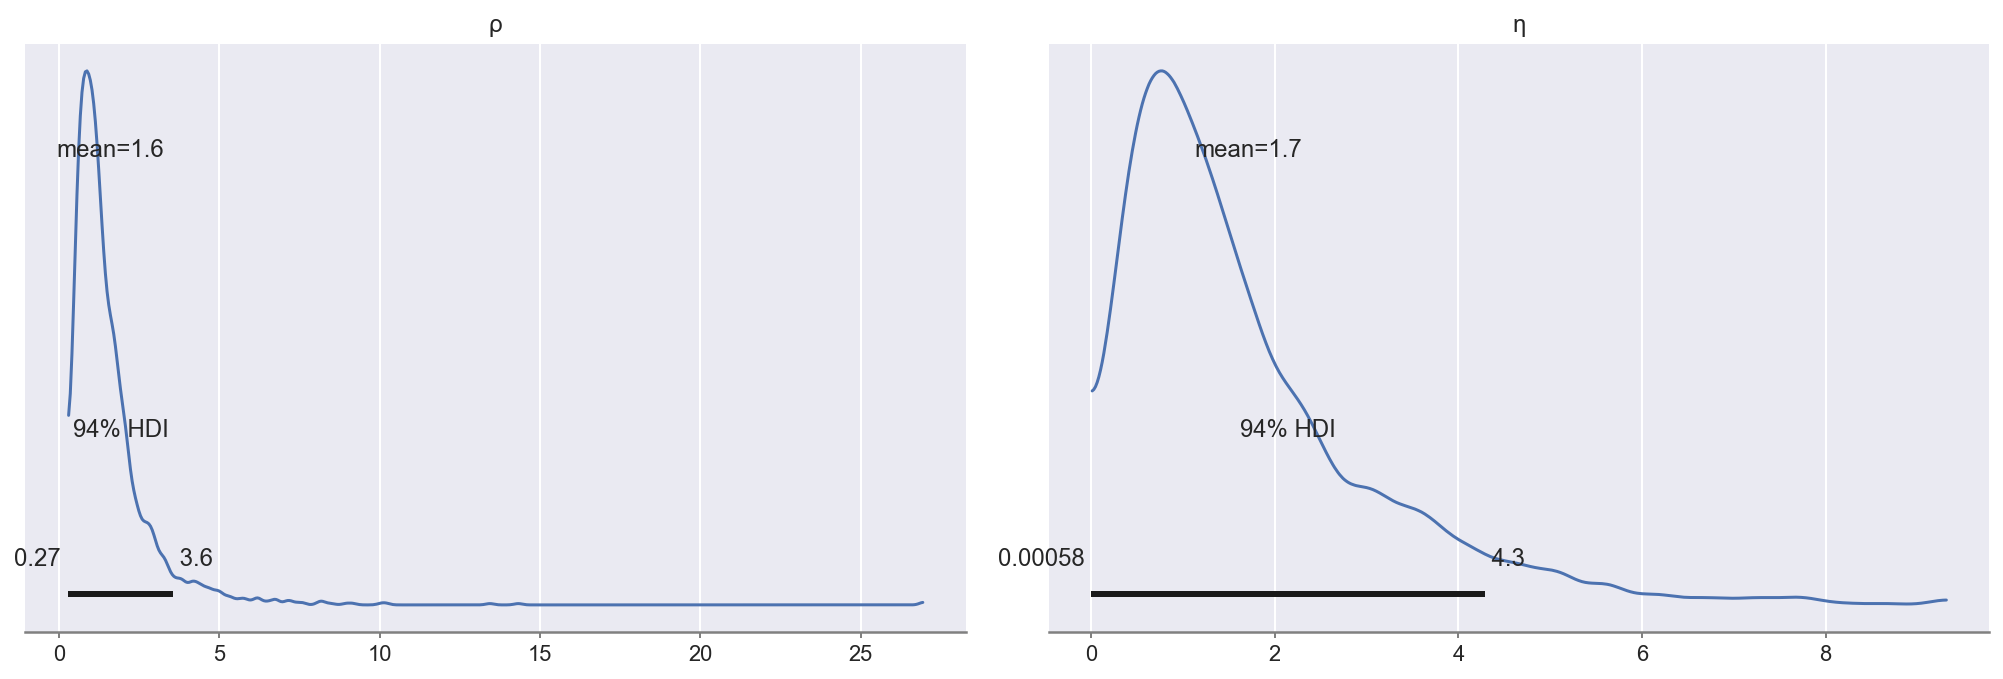

In [27]:
az.plot_posterior(trace, var_names=['ρ', 'η'])